In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Initial class distribution:
CKD_Stage
Stage 1     53415
Stage 2     20224
Stage 3a    10518
Stage 3b    10051
Stage 4      5554
Stage 5       238
Name: count, dtype: int64

Balanced class distribution:
CKD_Stage
Stage 1     10000
Stage 2     10000
Stage 3a    10000
Stage 3b    10000
Stage 4     10000
Stage 5     10000
Name: count, dtype: int64

Dataset Shape: (60000, 9)

Feature Statistics:
                Age    Creatinine           GFR    Blood_Urea    Hemoglobin  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      64.449873      1.797974     51.926808     55.295065     12.375473   
std       15.032082      1.019537     32.562436     42.084995      1.977899   
min       18.000000      0.600000     10.400000      7.000000      7.400000   
25%       54.400000      0.960000     24.800000     23.300000     10.900000   
50%       64.600000      1.510000     44.950000     39.800000     12.200000   
75%       75.000000      2.470000     76.600000     7

/tmp/ipykernel_30/2309788282.py:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When g

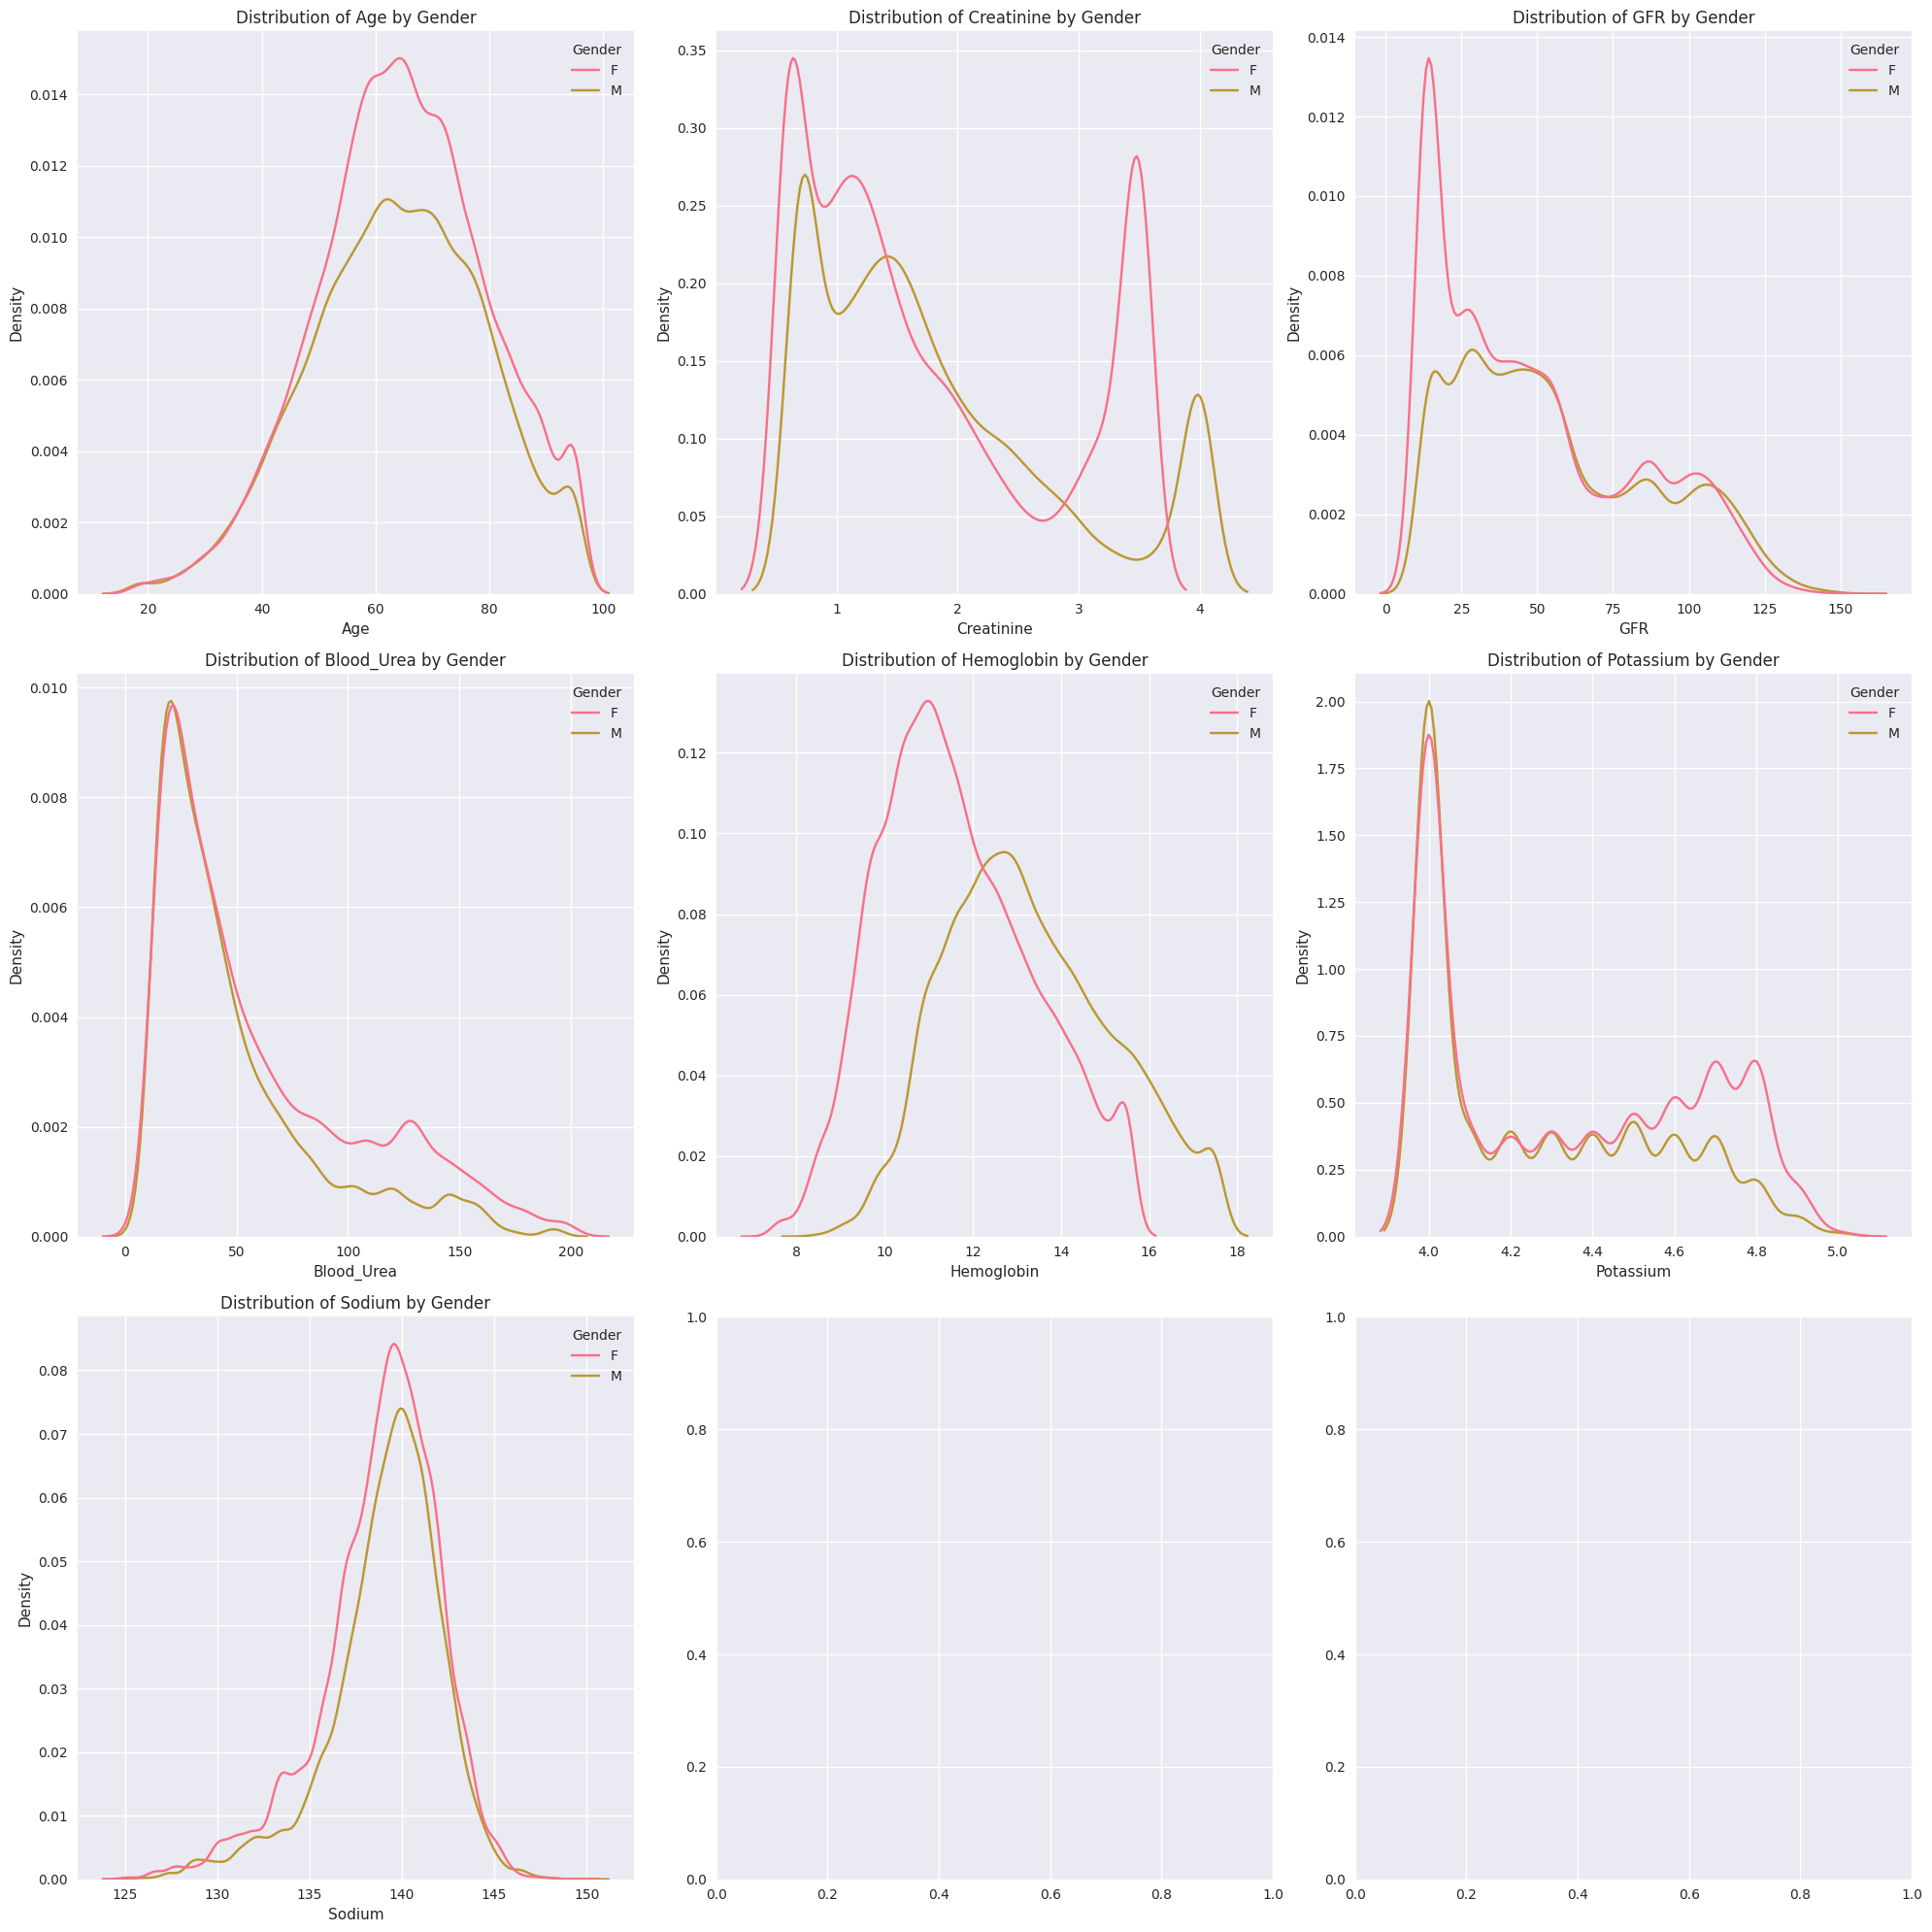

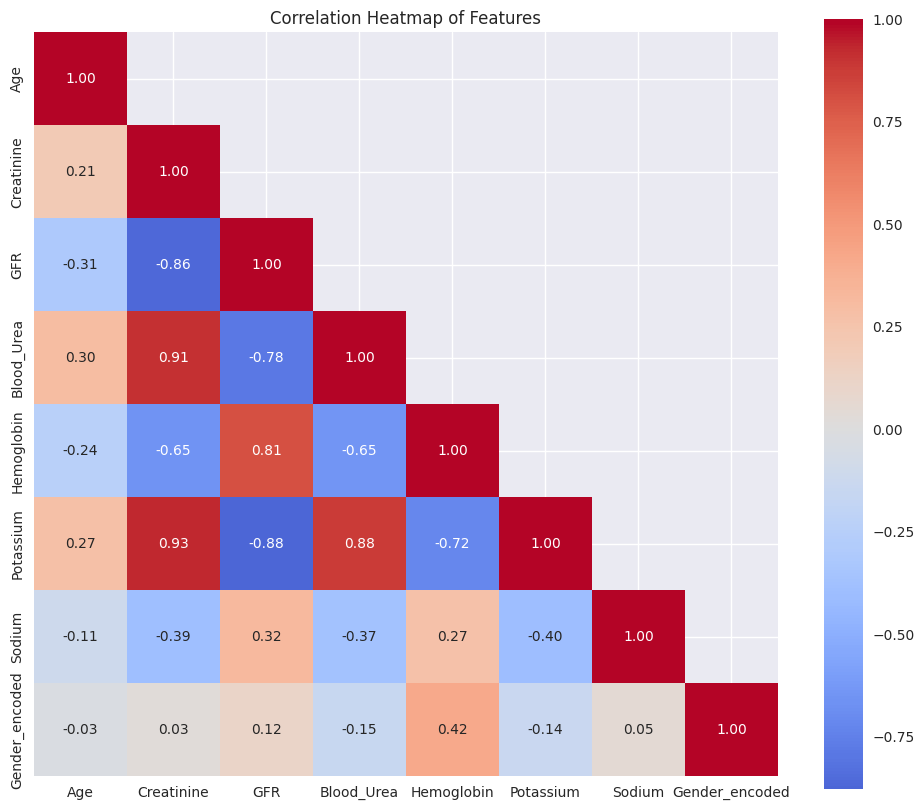

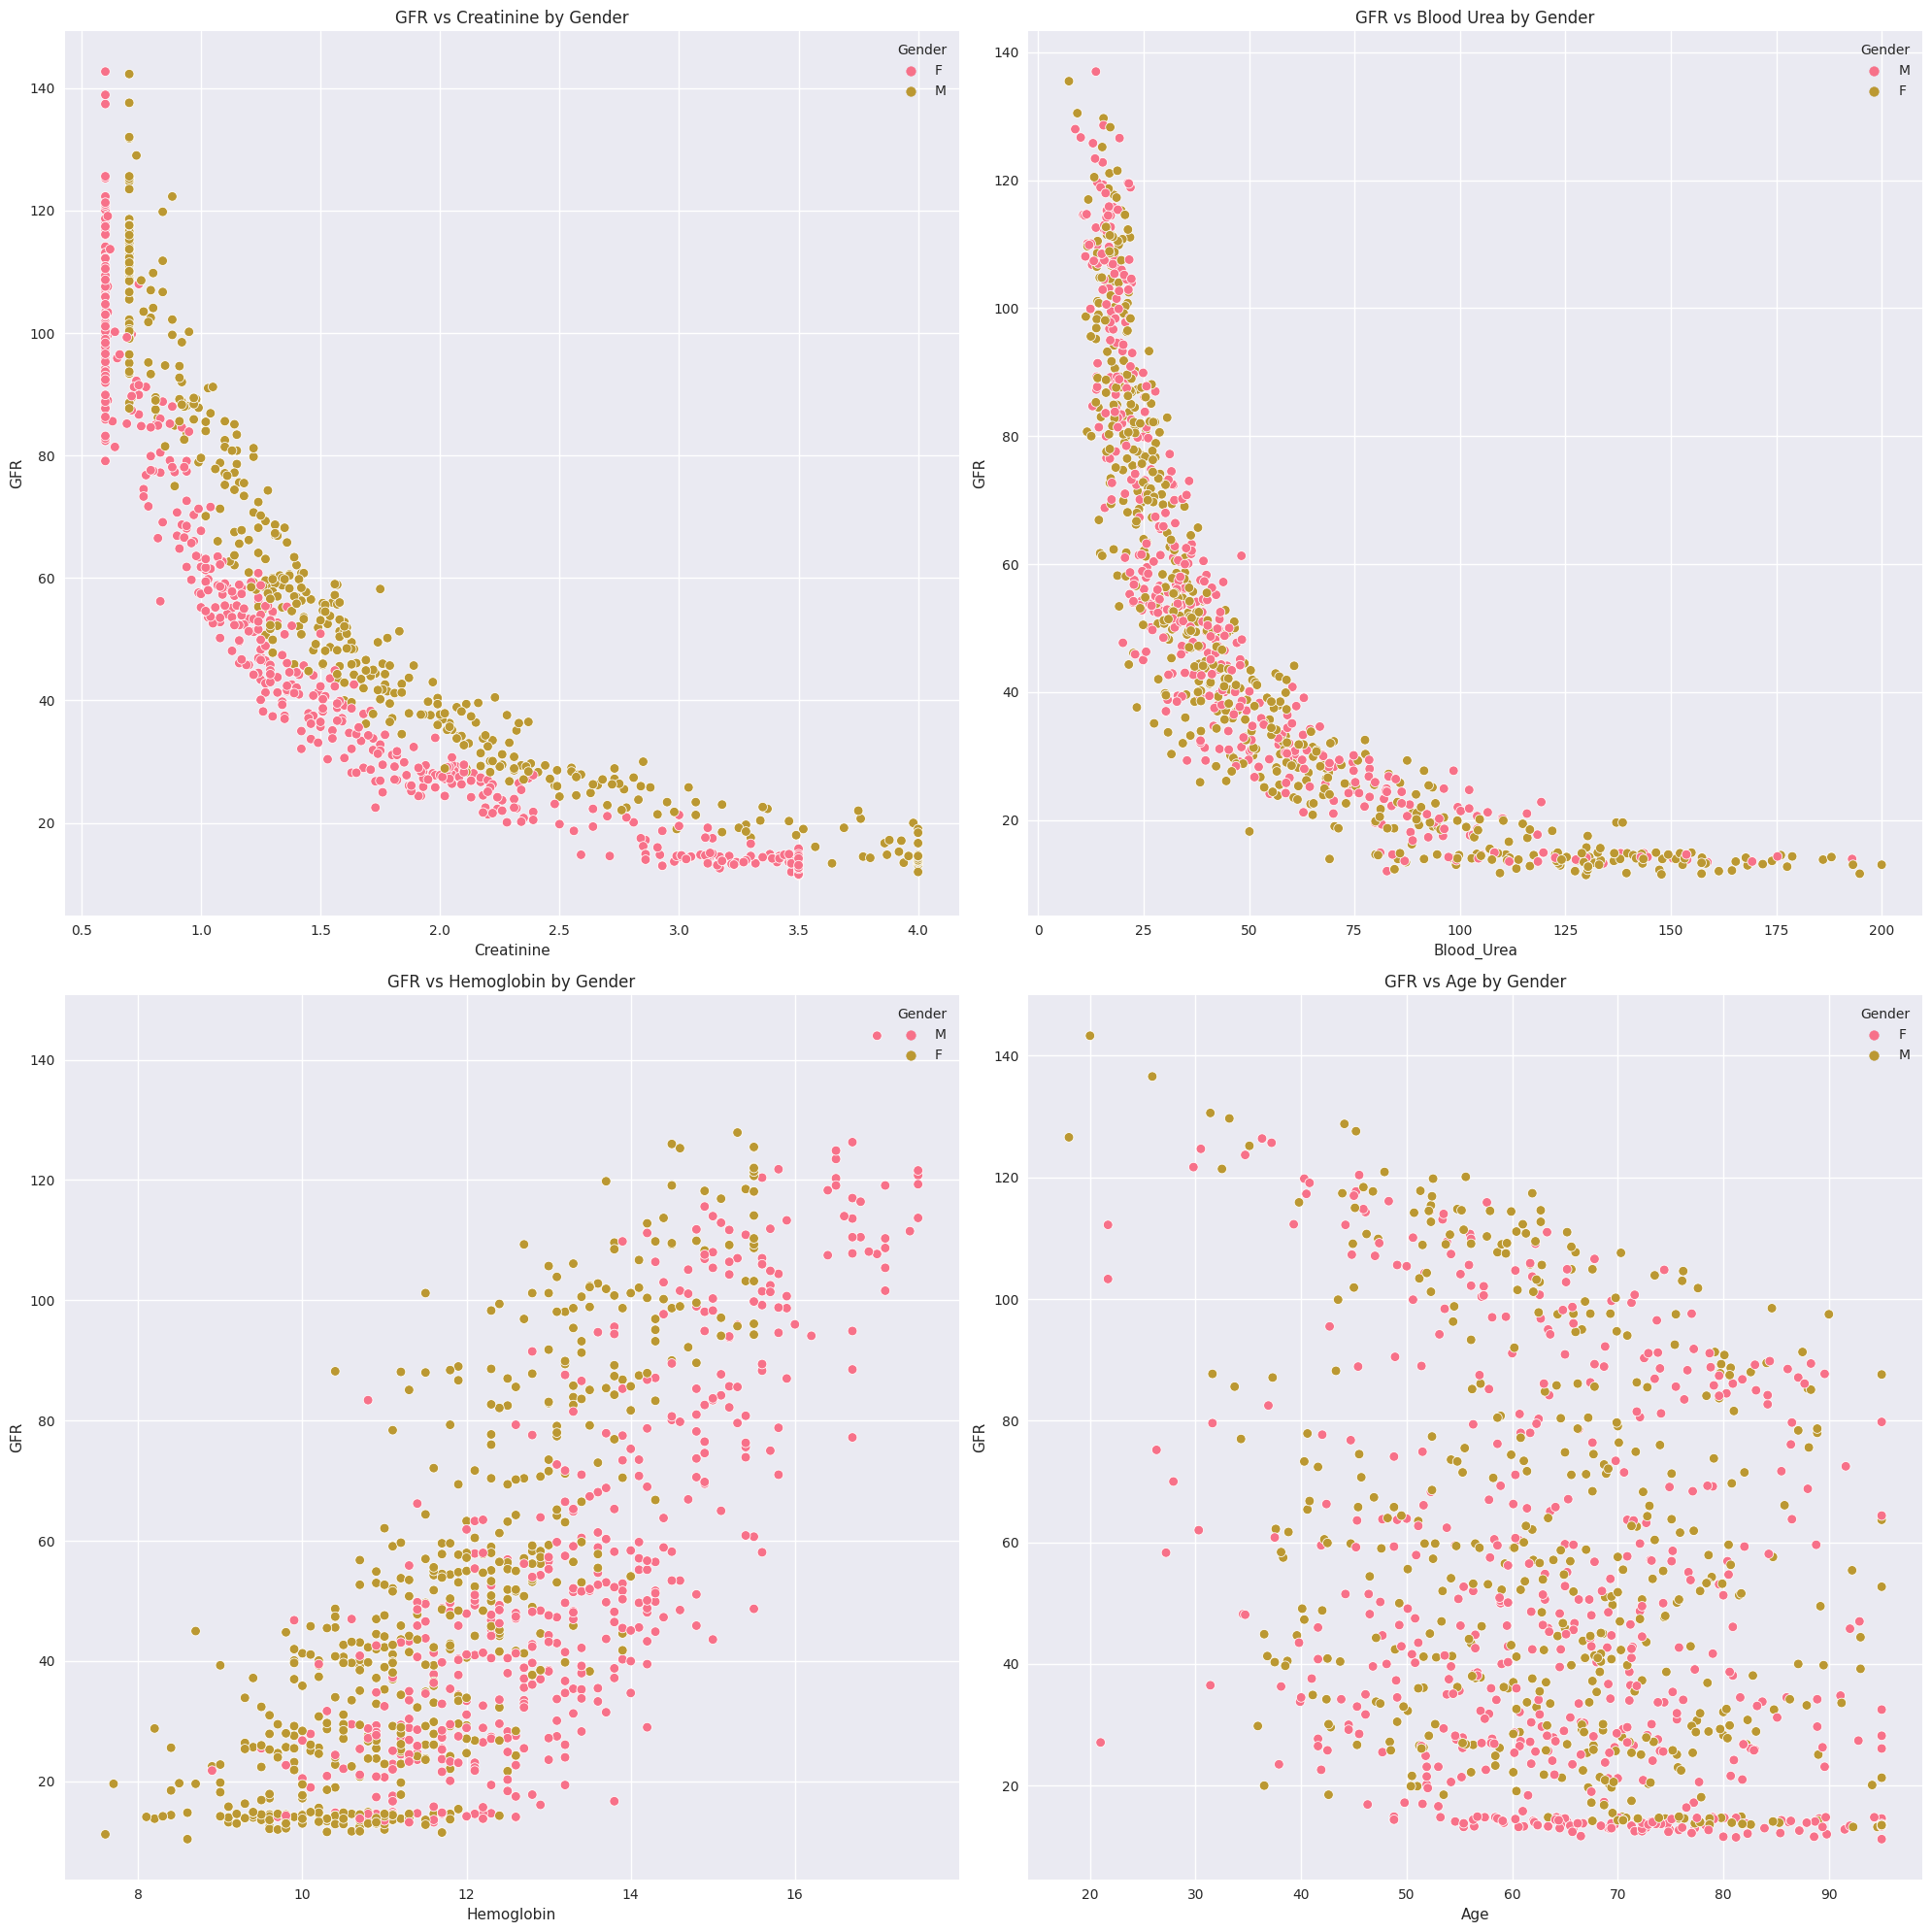

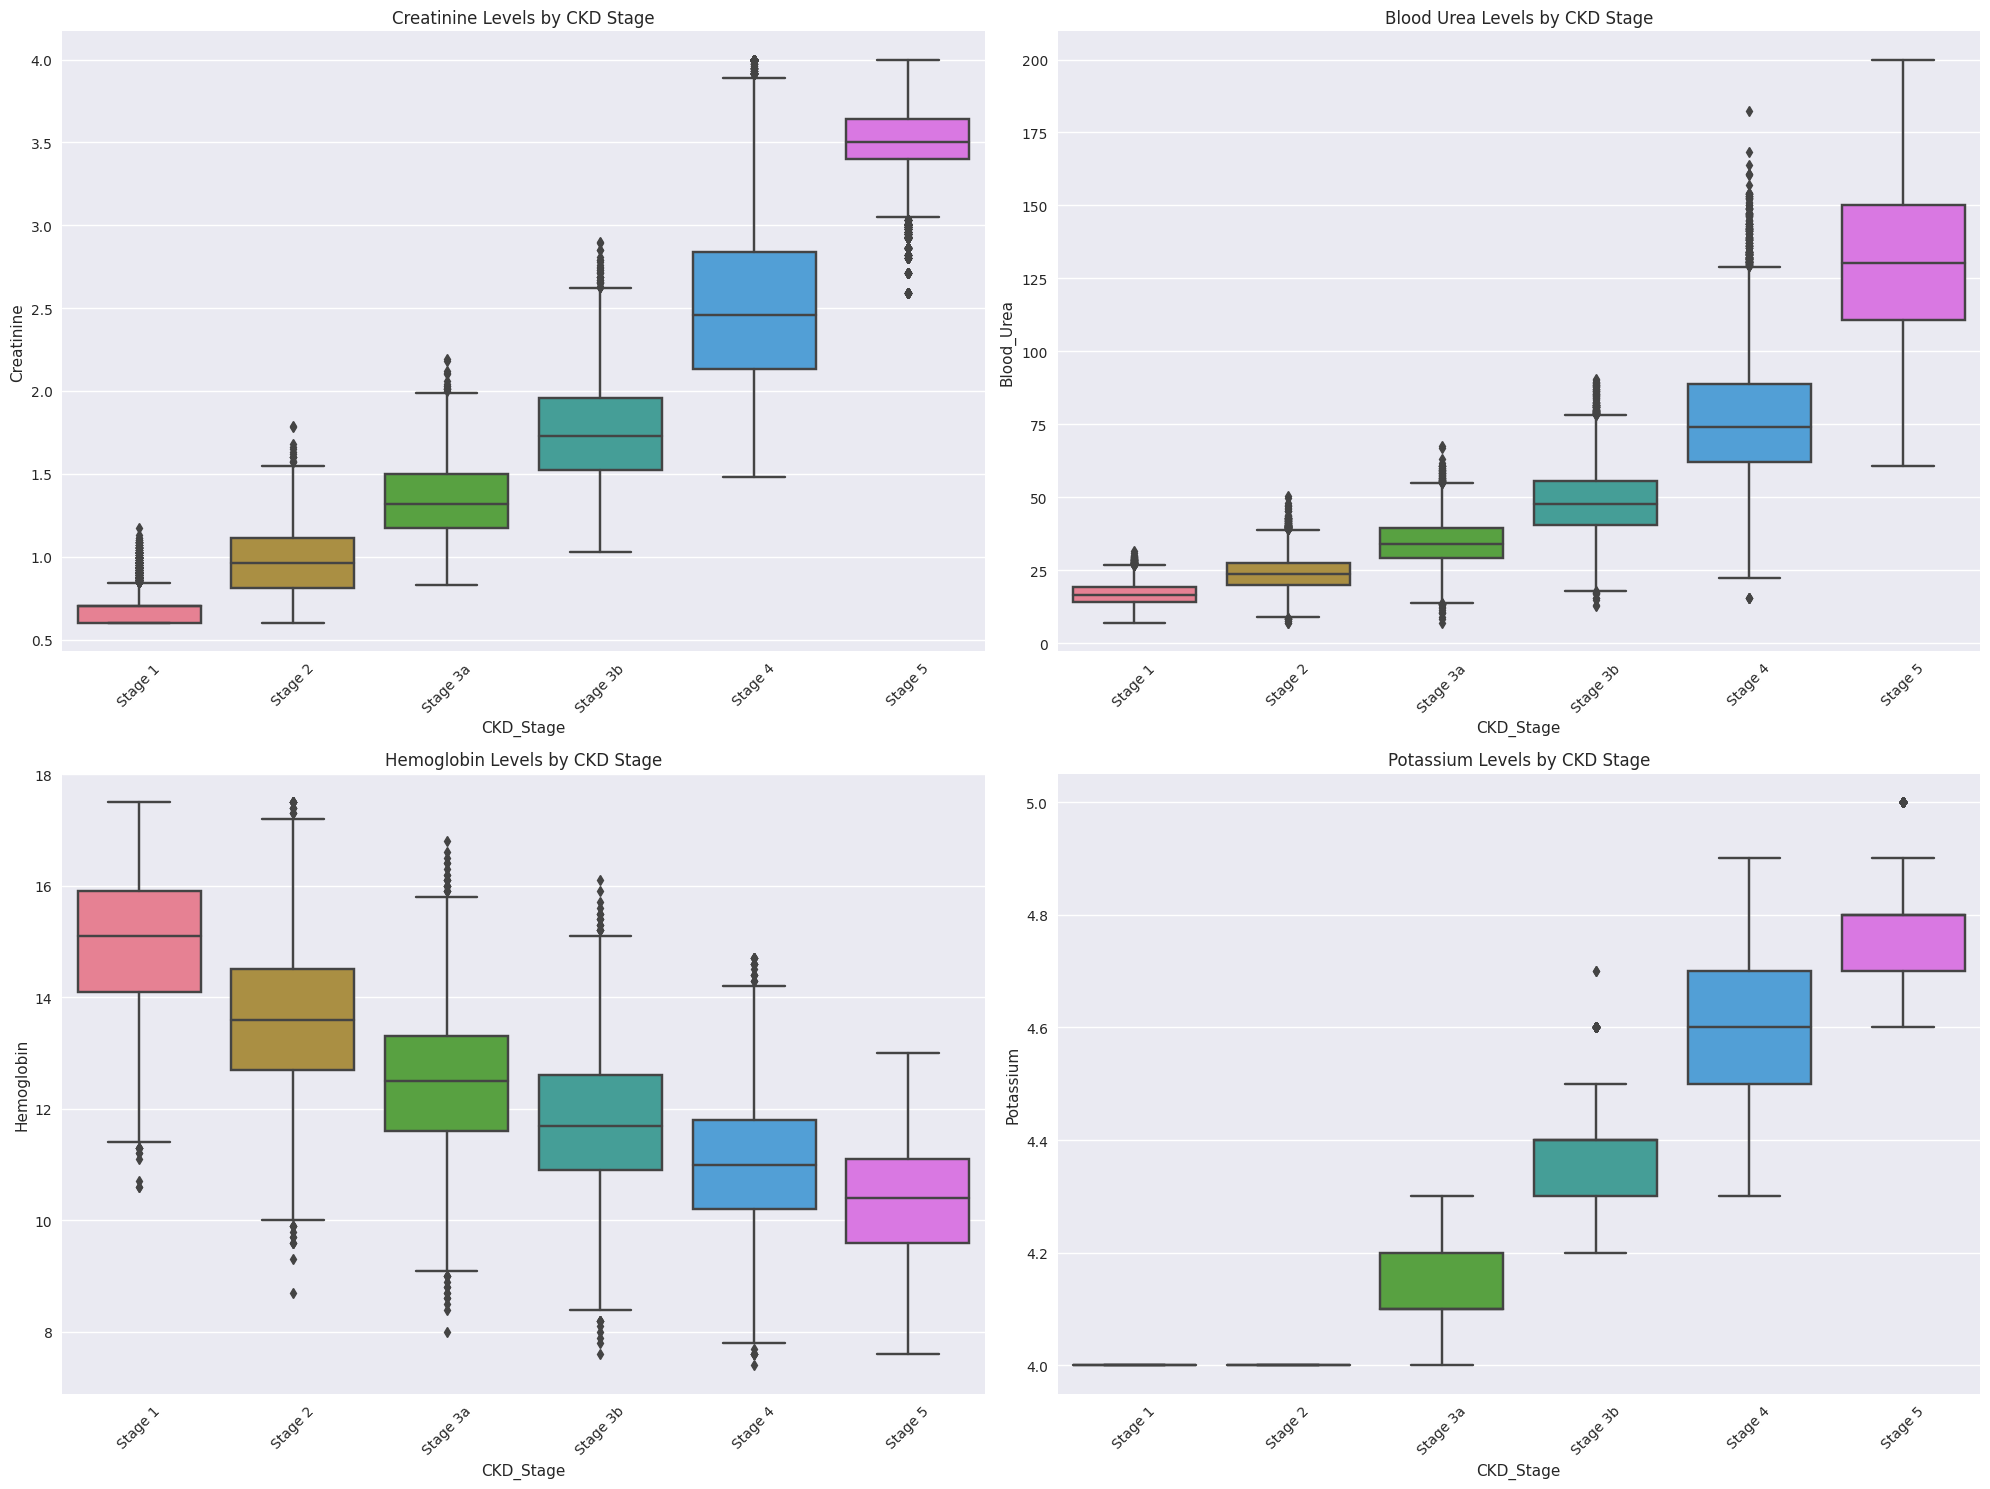

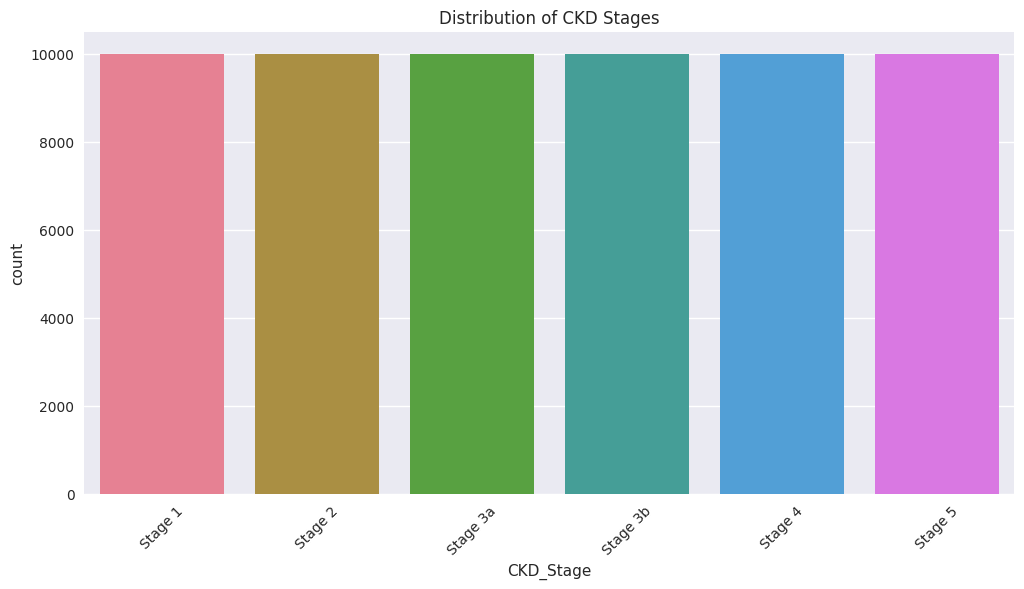


Dataset saved to 'ckd_balanced_dataset.csv'


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

def generate_natural_ckd_data(n_samples=100000, random_state=42):
    """
    Generate CKD data naturally without enforcing stages
    """
    np.random.seed(random_state)
    
    # Generate demographic data with natural age distribution
    ages = np.random.normal(60, 15, n_samples)
    ages = np.clip(ages, 18, 95)
    gender = np.random.choice(['M', 'F'], size=n_samples)

    # Initialize arrays
    creatinine = np.zeros(n_samples)
    gfr = np.zeros(n_samples)
    
    # Generate creatinine naturally based on age and gender
    for i in range(n_samples):
        # Add age effect on creatinine
        age_factor = (ages[i] - 60) * 0.005  # Slight increase with age
        
        if gender[i] == 'M':
            # Male base distribution
            base_cr = np.random.gamma(shape=2, scale=0.5)  # Natural right-skewed distribution
            creatinine[i] = np.clip(base_cr + age_factor, 0.7, 4.0)
        else:
            # Female base distribution (typically lower)
            base_cr = np.random.gamma(shape=1.8, scale=0.45)
            creatinine[i] = np.clip(base_cr + age_factor, 0.6, 3.5)
    
    # Calculate GFR using CKD-EPI equation
    for i in range(n_samples):
        k = 0.7 if gender[i] == 'F' else 0.9
        a = -0.329 if gender[i] == 'F' else -0.411
        
        # Add natural biological variation
        biological_variation = np.random.normal(1, 0.05)
        
        gfr[i] = (142 * min(creatinine[i]/k, 1)**a * max(creatinine[i]/k, 1)**-1.200 * 
                 0.9938**ages[i] * (1.012 if gender[i] == 'F' else 1)) * biological_variation
    
    # Generate other measurements based on the natural GFR values
    blood_urea = 20 * (90/np.maximum(gfr, 1)) * np.random.normal(1, 0.2, n_samples)
    blood_urea = np.clip(blood_urea, 7, 200)
    
    # Hemoglobin with gender-specific ranges
    hemoglobin = np.zeros(n_samples)
    for i in range(n_samples):
        if gender[i] == 'M':
            base_hgb = 15 * (0.7 + 0.3 * (gfr[i]/90))
            hemoglobin[i] = np.clip(base_hgb + np.random.normal(0, 1), 6, 17.5)
        else:
            base_hgb = 13.5 * (0.7 + 0.3 * (gfr[i]/90))
            hemoglobin[i] = np.clip(base_hgb + np.random.normal(0, 1), 6, 15.5)
    
    # Potassium and Sodium with natural relationships to GFR
    potassium = 4.0 + np.maximum(0, (60 - gfr)/60) * np.random.normal(1, 0.1, n_samples)
    potassium = np.clip(potassium, 3.0, 7.0)
    
    sodium = np.where(gfr < 30,
                     np.random.normal(137, 4, n_samples),
                     np.random.normal(140, 2, n_samples))
    sodium = np.clip(sodium, 125, 150)
    
    # Create DataFrame
    data = pd.DataFrame({
        'Age': np.round(ages, 1),
        'Gender': gender,
        'Creatinine': np.round(creatinine, 2),
        'GFR': np.round(gfr, 1),
        'Blood_Urea': np.round(blood_urea, 1),
        'Hemoglobin': np.round(hemoglobin, 1),
        'Potassium': np.round(potassium, 1),
        'Sodium': np.round(sodium, 1)
    })
    
    # Add CKD stages based on GFR values (after natural generation)
    conditions = [
        (data['GFR'] >= 90),
        (data['GFR'] >= 60) & (data['GFR'] < 90),
        (data['GFR'] >= 45) & (data['GFR'] < 60),
        (data['GFR'] >= 30) & (data['GFR'] < 45),
        (data['GFR'] >= 15) & (data['GFR'] < 30),
        (data['GFR'] < 15)
    ]
    stages = ['Stage 1', 'Stage 2', 'Stage 3a', 'Stage 3b', 'Stage 4', 'Stage 5']
    data['CKD_Stage'] = np.select(conditions, stages)
    
    return data

def balance_dataset(data, samples_per_class=10000):
    """
    Balance the dataset to have equal representation of all classes
    """
    stages = ['Stage 1', 'Stage 2', 'Stage 3a', 'Stage 3b', 'Stage 4', 'Stage 5']
    
    balanced_dfs = []
    for stage in stages:
        stage_data = data[data['CKD_Stage'] == stage]
        if len(stage_data) < samples_per_class:
            # Oversample if we have too few samples
            stage_balanced = resample(stage_data, 
                                   replace=True,
                                   n_samples=samples_per_class,
                                   random_state=42)
        else:
            # Undersample if we have too many samples
            stage_balanced = resample(stage_data,
                                   replace=False,
                                   n_samples=samples_per_class,
                                   random_state=42)
        balanced_dfs.append(stage_balanced)
    
    return pd.concat(balanced_dfs, ignore_index=True)

def create_visualizations(data):
    """
    Create comprehensive visualizations of the dataset
    """
    # Set up the style
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # 1. Distribution plots for each numerical variable by gender
    numerical_cols = ['Age', 'Creatinine', 'GFR', 'Blood_Urea', 'Hemoglobin', 'Potassium', 'Sodium']
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    axes = axes.ravel()
    
    for idx, col in enumerate(numerical_cols):
        sns.kdeplot(data=data, x=col, hue='Gender', ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col} by Gender')
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation Heatmap
    plt.figure(figsize=(12, 10))
    data['Gender_encoded'] = (data['Gender'] == 'M').astype(int)
    correlation_matrix = data[numerical_cols + ['Gender_encoded']].corr()
    mask = np.triu(np.ones_like(correlation_matrix), k=1)
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                mask=mask,
                square=True,
                fmt='.2f')
    plt.title('Correlation Heatmap of Features')
    plt.show()
    
    # 3. Scatter plots of key relationships with GFR
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.ravel()
    
    # GFR vs Creatinine
    sns.scatterplot(data=data.sample(1000), x='Creatinine', y='GFR', hue='Gender', ax=axes[0])
    axes[0].set_title('GFR vs Creatinine by Gender')
    
    # GFR vs Blood_Urea
    sns.scatterplot(data=data.sample(1000), x='Blood_Urea', y='GFR', hue='Gender', ax=axes[1])
    axes[1].set_title('GFR vs Blood Urea by Gender')
    
    # GFR vs Hemoglobin
    sns.scatterplot(data=data.sample(1000), x='Hemoglobin', y='GFR', hue='Gender', ax=axes[2])
    axes[2].set_title('GFR vs Hemoglobin by Gender')
    
    # GFR vs Age
    sns.scatterplot(data=data.sample(1000), x='Age', y='GFR', hue='Gender', ax=axes[3])
    axes[3].set_title('GFR vs Age by Gender')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Box plots for CKD stages
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.ravel()
    
    sns.boxplot(data=data, x='CKD_Stage', y='Creatinine', ax=axes[0])
    axes[0].set_title('Creatinine Levels by CKD Stage')
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=data, x='CKD_Stage', y='Blood_Urea', ax=axes[1])
    axes[1].set_title('Blood Urea Levels by CKD Stage')
    axes[1].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=data, x='CKD_Stage', y='Hemoglobin', ax=axes[2])
    axes[2].set_title('Hemoglobin Levels by CKD Stage')
    axes[2].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=data, x='CKD_Stage', y='Potassium', ax=axes[3])
    axes[3].set_title('Potassium Levels by CKD Stage')
    axes[3].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Distribution of CKD Stages
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x='CKD_Stage', 
                 order=['Stage 1', 'Stage 2', 'Stage 3a', 'Stage 3b', 'Stage 4', 'Stage 5'])
    plt.title('Distribution of CKD Stages')
    plt.xticks(rotation=45)
    plt.show()

# Generate and process the data
initial_data = generate_natural_ckd_data(n_samples=100000)
print("Initial class distribution:")
print(initial_data['CKD_Stage'].value_counts())

# Balance the dataset with 10k samples per class
balanced_data = balance_dataset(initial_data, samples_per_class=10000)
print("\nBalanced class distribution:")
print(balanced_data['CKD_Stage'].value_counts())

# Print summary statistics
print("\nDataset Shape:", balanced_data.shape)
print("\nFeature Statistics:")
print(balanced_data.describe())

# Create visualizations
create_visualizations(balanced_data)

# Save the dataset
balanced_data.to_csv('ckd_balanced_dataset.csv', index=False)
print("\nDataset saved to 'ckd_balanced_dataset.csv'")


-------------------- Logistic Regression Results --------------------

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2004
           1       0.98      0.98      0.98      1959
           2       0.94      0.96      0.95      1946
           3       0.95      0.93      0.94      2068
           4       0.96      0.94      0.95      1999
           5       0.96      0.99      0.98      2024

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



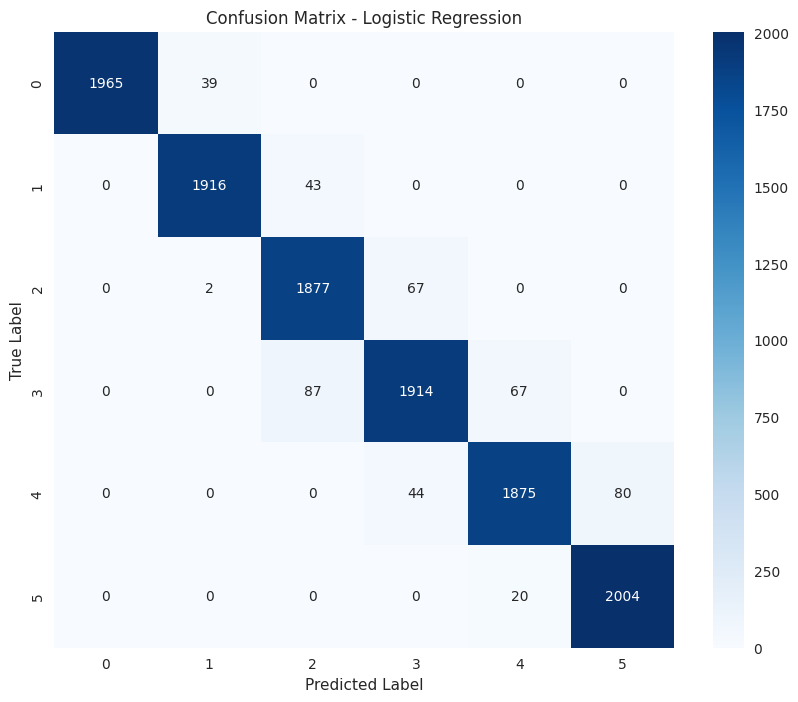


Cross-validation scores: [0.96291667 0.96072917 0.964375   0.96354167 0.963125  ]
Average CV score: 0.963 (+/- 0.002)

-------------------- Support Vector Machine Results --------------------

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2004
           1       0.97      0.97      0.97      1959
           2       0.92      0.96      0.94      1946
           3       0.94      0.93      0.94      2068
           4       0.97      0.95      0.96      1999
           5       0.97      1.00      0.98      2024

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



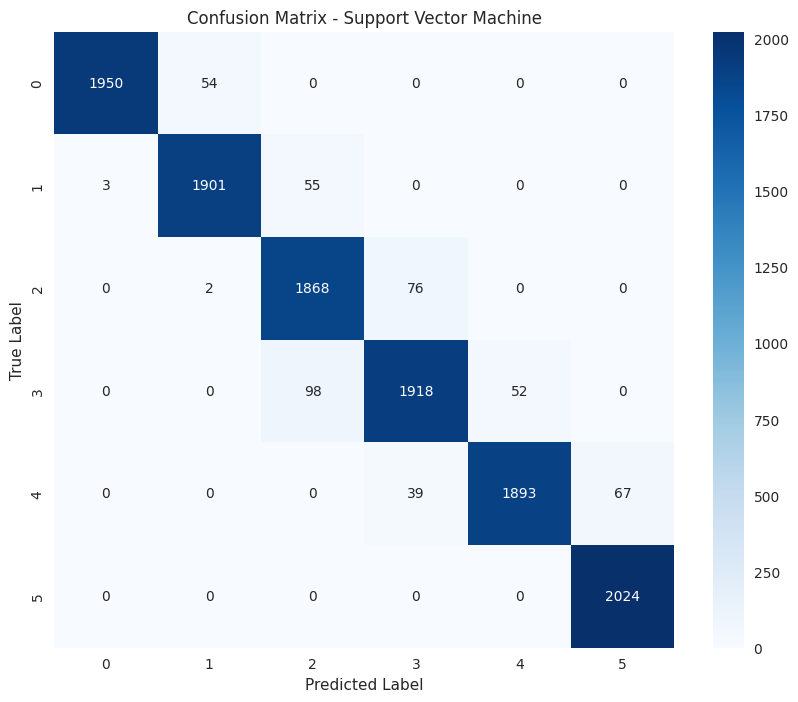


Cross-validation scores: [0.96302083 0.95854167 0.96083333 0.9640625  0.96260417]
Average CV score: 0.962 (+/- 0.004)

-------------------- Decision Tree Results --------------------

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2004
           1       1.00      1.00      1.00      1959
           2       1.00      1.00      1.00      1946
           3       1.00      1.00      1.00      2068
           4       1.00      1.00      1.00      1999
           5       1.00      1.00      1.00      2024

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



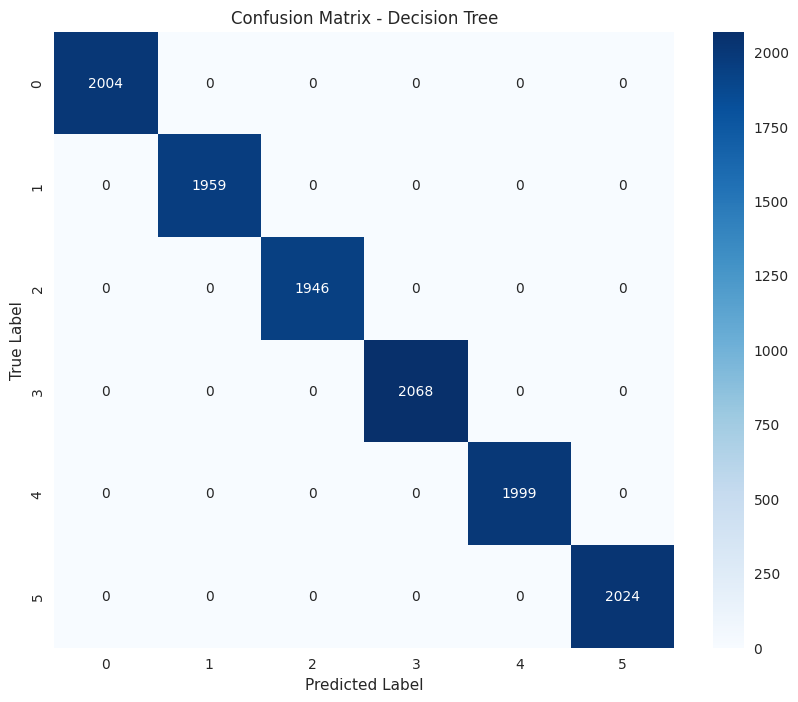


Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV score: 1.000 (+/- 0.000)

-------------------- Random Forest Results --------------------

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2004
           1       1.00      1.00      1.00      1959
           2       1.00      1.00      1.00      1946
           3       1.00      1.00      1.00      2068
           4       1.00      1.00      1.00      1999
           5       1.00      1.00      1.00      2024

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



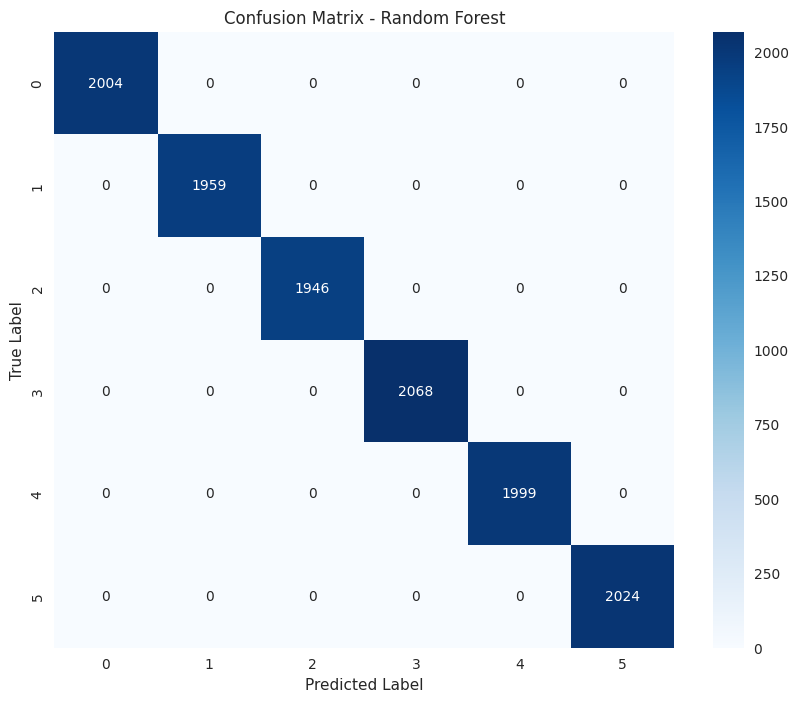


Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV score: 1.000 (+/- 0.000)

-------------------- K-Nearest Neighbors Results --------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2004
           1       0.91      0.94      0.92      1959
           2       0.91      0.91      0.91      1946
           3       0.94      0.90      0.92      2068
           4       0.95      0.95      0.95      1999
           5       0.99      1.00      0.99      2024

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.95      0.94      0.94     12000



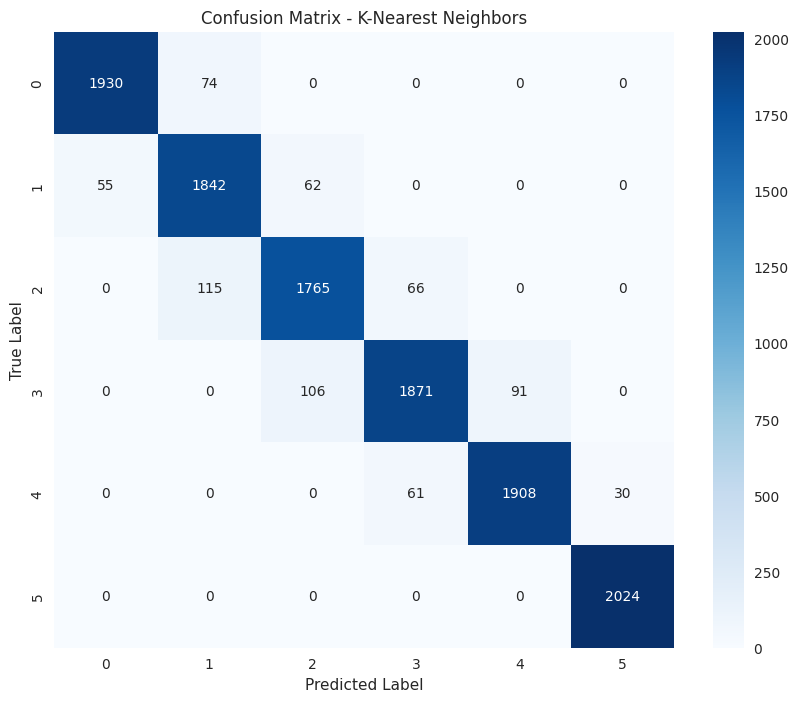


Cross-validation scores: [0.94458333 0.93708333 0.939375   0.93947917 0.93572917]
Average CV score: 0.939 (+/- 0.006)


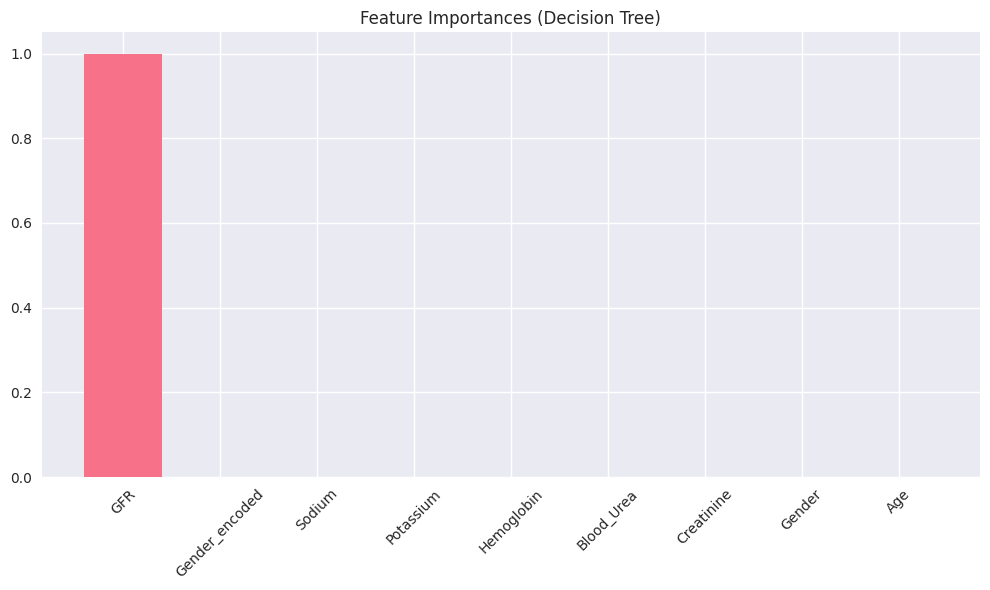

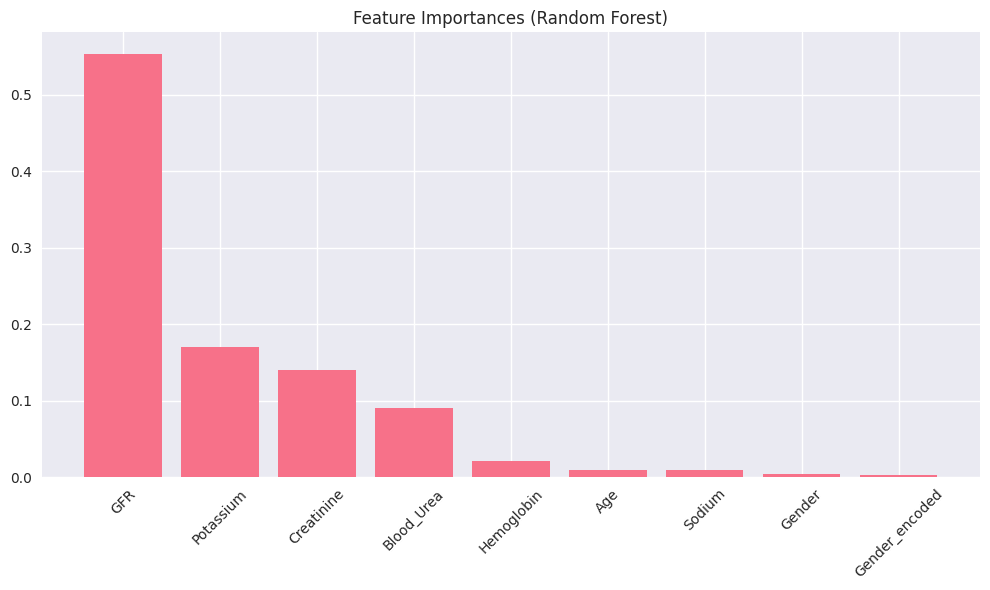

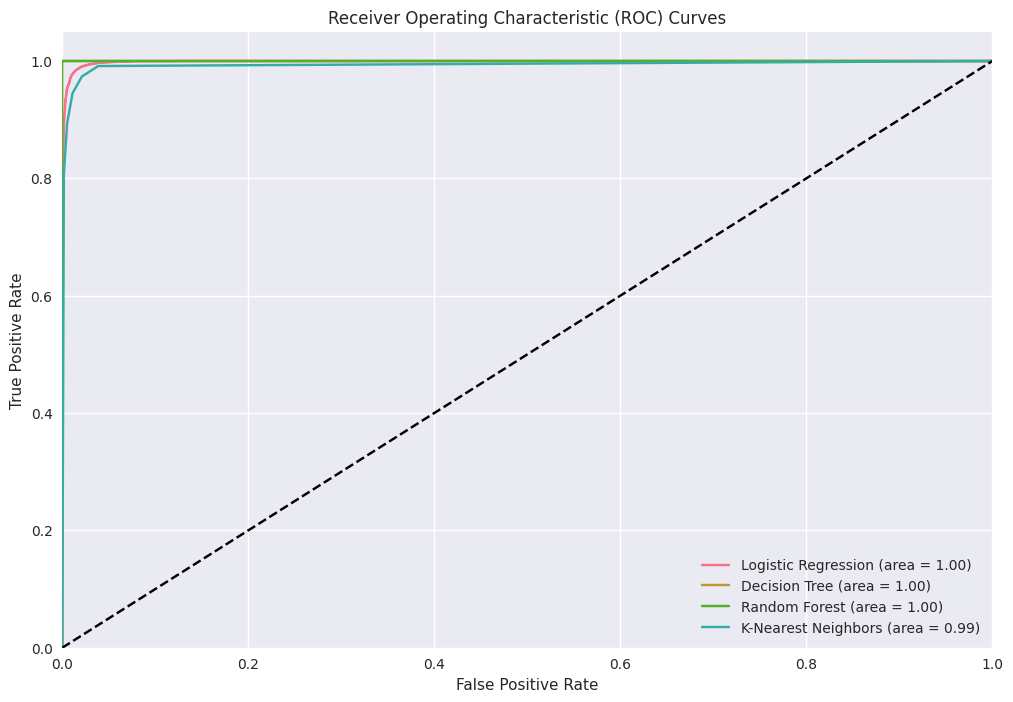


Model Performance Comparison:
                    Model  Accuracy
2           Decision Tree  1.000000
3           Random Forest  1.000000
1  Support Vector Machine  0.962833
0     Logistic Regression  0.962583
4     K-Nearest Neighbors  0.945000

Best performing model: Logistic Regression

Additional Insights:
1. Feature correlations with CKD Stage:
CKD_Stage         1.000000
Potassium         0.945114
Creatinine        0.925060
Blood_Urea        0.861806
Age               0.296034
Gender           -0.135644
Gender_encoded   -0.135644
Sodium           -0.375882
Hemoglobin       -0.778912
GFR              -0.958196
Name: CKD_Stage, dtype: float64

Results have been saved to 'ckd_classification_results.txt'


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

# Load the balanced dataset
data = balanced_data.copy()

# Prepare the data for ML
def prepare_data(data):
    # Encode categorical variables
    le = LabelEncoder()
    data['Gender'] = le.fit_transform(data['Gender'])
    data['CKD_Stage'] = le.fit_transform(data['CKD_Stage'])
    
    # Split features and target
    X = data.drop(['CKD_Stage'], axis=1)
    y = data['CKD_Stage']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return model, y_pred

# Prepare the data
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(data)

# Create and evaluate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(kernel='rbf'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    trained_model, predictions = evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test, name
    )
    results[name] = {
        'model': trained_model,
        'predictions': predictions
    }

# Feature importance analysis for tree-based models
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances ({model_name})')
        plt.bar(range(X_train_scaled.shape[1]), importances[indices])
        plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()

# Plot feature importance for Decision Tree and Random Forest
feature_names = data.drop(['CKD_Stage'], axis=1).columns
plot_feature_importance(results['Decision Tree']['model'], feature_names, 'Decision Tree')
plot_feature_importance(results['Random Forest']['model'], feature_names, 'Random Forest')

# ROC curves for multi-class classification
def plot_roc_curves(X_test_scaled, y_test, models):
    plt.figure(figsize=(12, 8))
    
    # Binarize the output for ROC curve
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]
    
    for name, result in models.items():
        model = result['model']
        
        # For models that don't naturally support probability prediction
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test_scaled)
        else:
            continue
            
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'{name} (area = {roc_auc["micro"]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves
plot_roc_curves(X_test_scaled, y_test, results)

# Compare model performances
performance_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [classification_report(y_test, results[model]['predictions'], output_dict=True)['accuracy'] 
                 for model in results.keys()]
})

print("\nModel Performance Comparison:")
print(performance_comparison.sort_values('Accuracy', ascending=False))

# Save the best model
best_model_name = performance_comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest performing model: {best_model_name}")

# Additional insights
print("\nAdditional Insights:")
print("1. Feature correlations with CKD Stage:")
correlations = data.corr()['CKD_Stage'].sort_values(ascending=False)
print(correlations)

# Save results to file
with open('ckd_classification_results.txt', 'w') as f:
    f.write("CKD Classification Results\n")
    f.write("========================\n\n")
    for name in results:
        f.write(f"{name} Results:\n")
        f.write(classification_report(y_test, results[name]['predictions']))
        f.write("\n\n")

print("\nResults have been saved to 'ckd_classification_results.txt'")

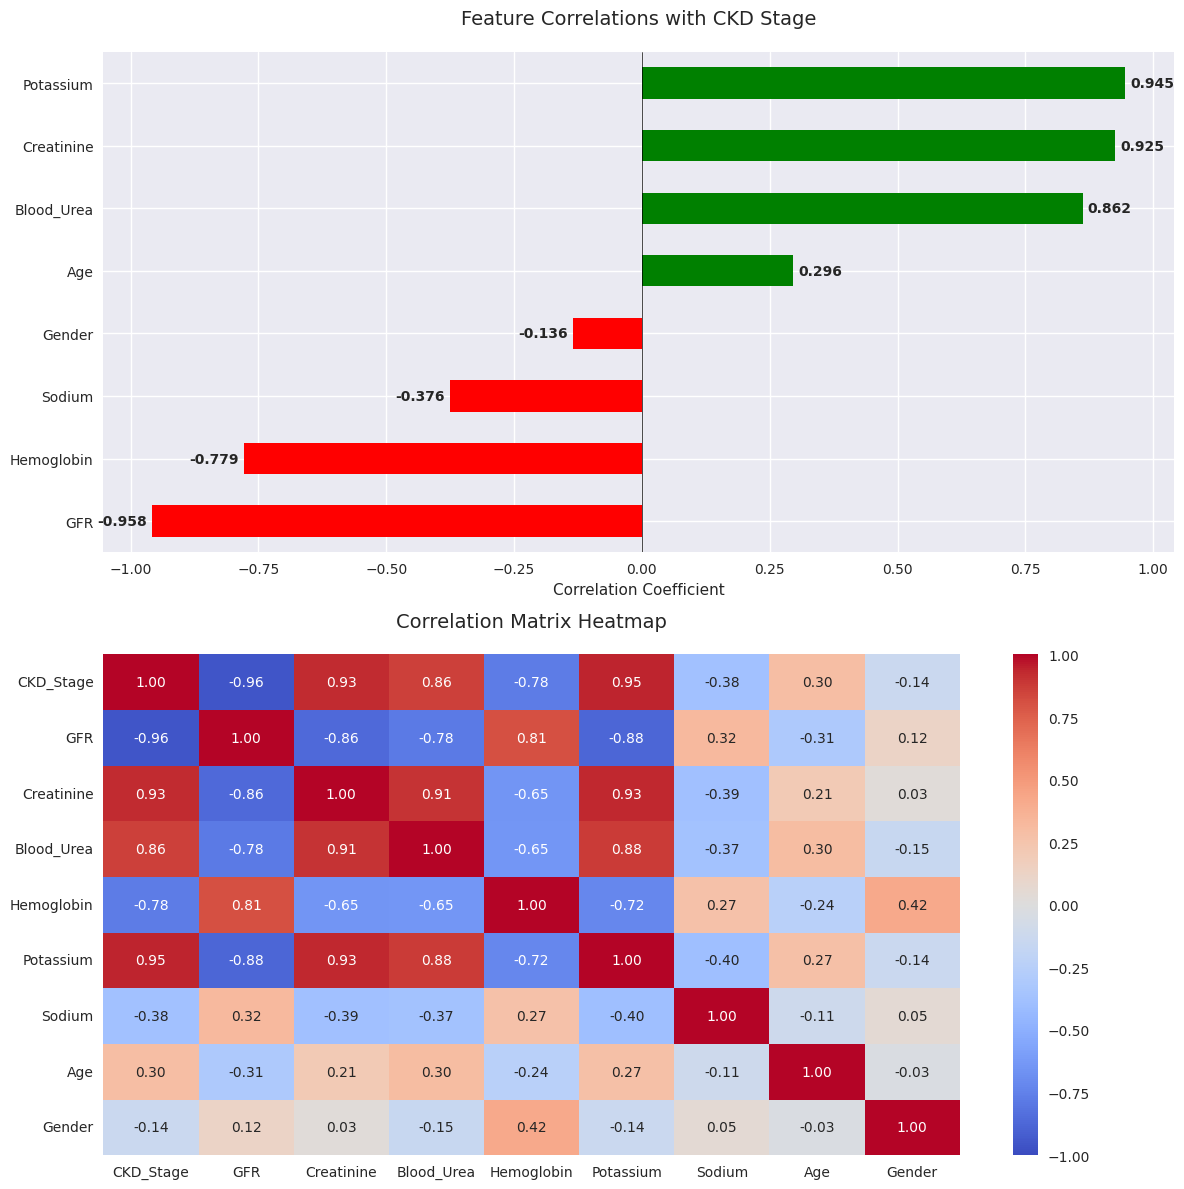

<Figure size 1500x1500 with 0 Axes>

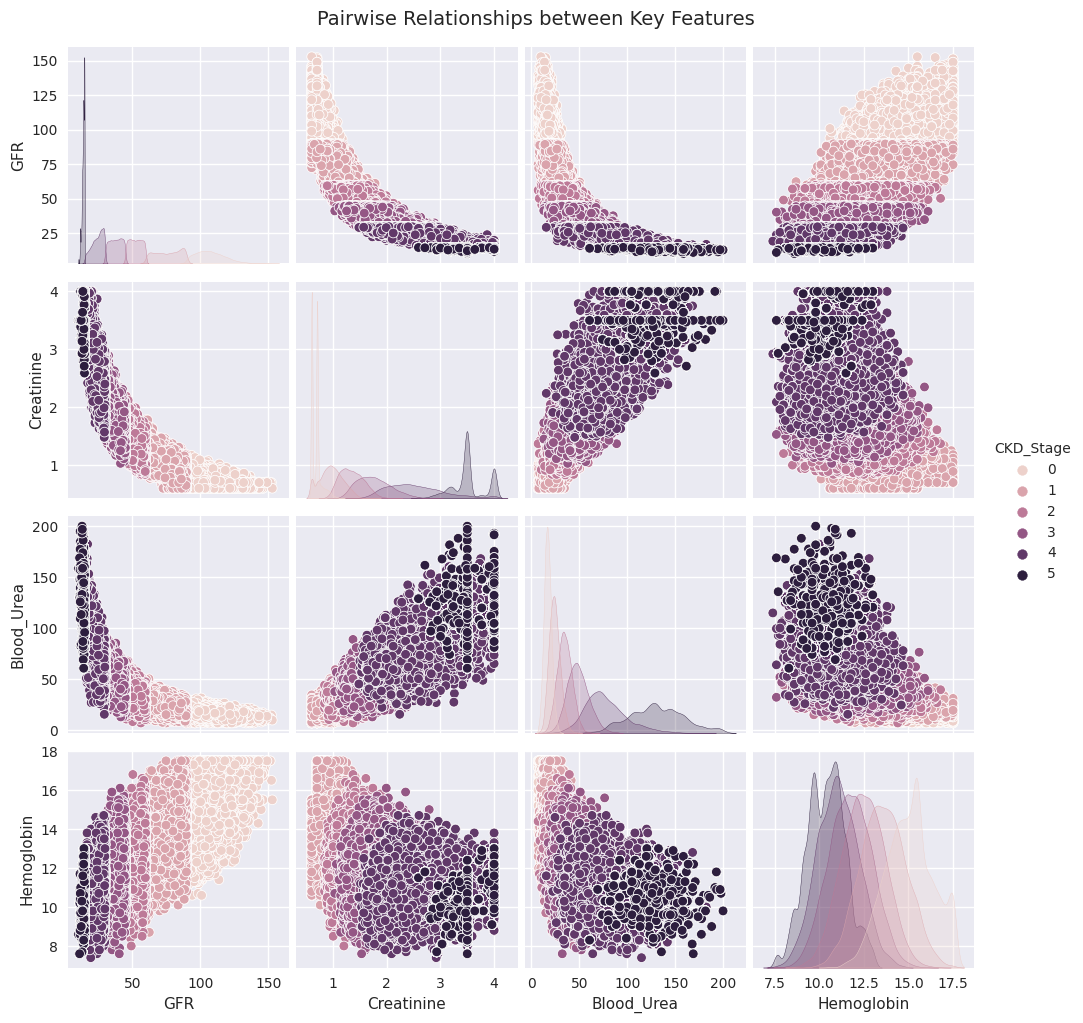

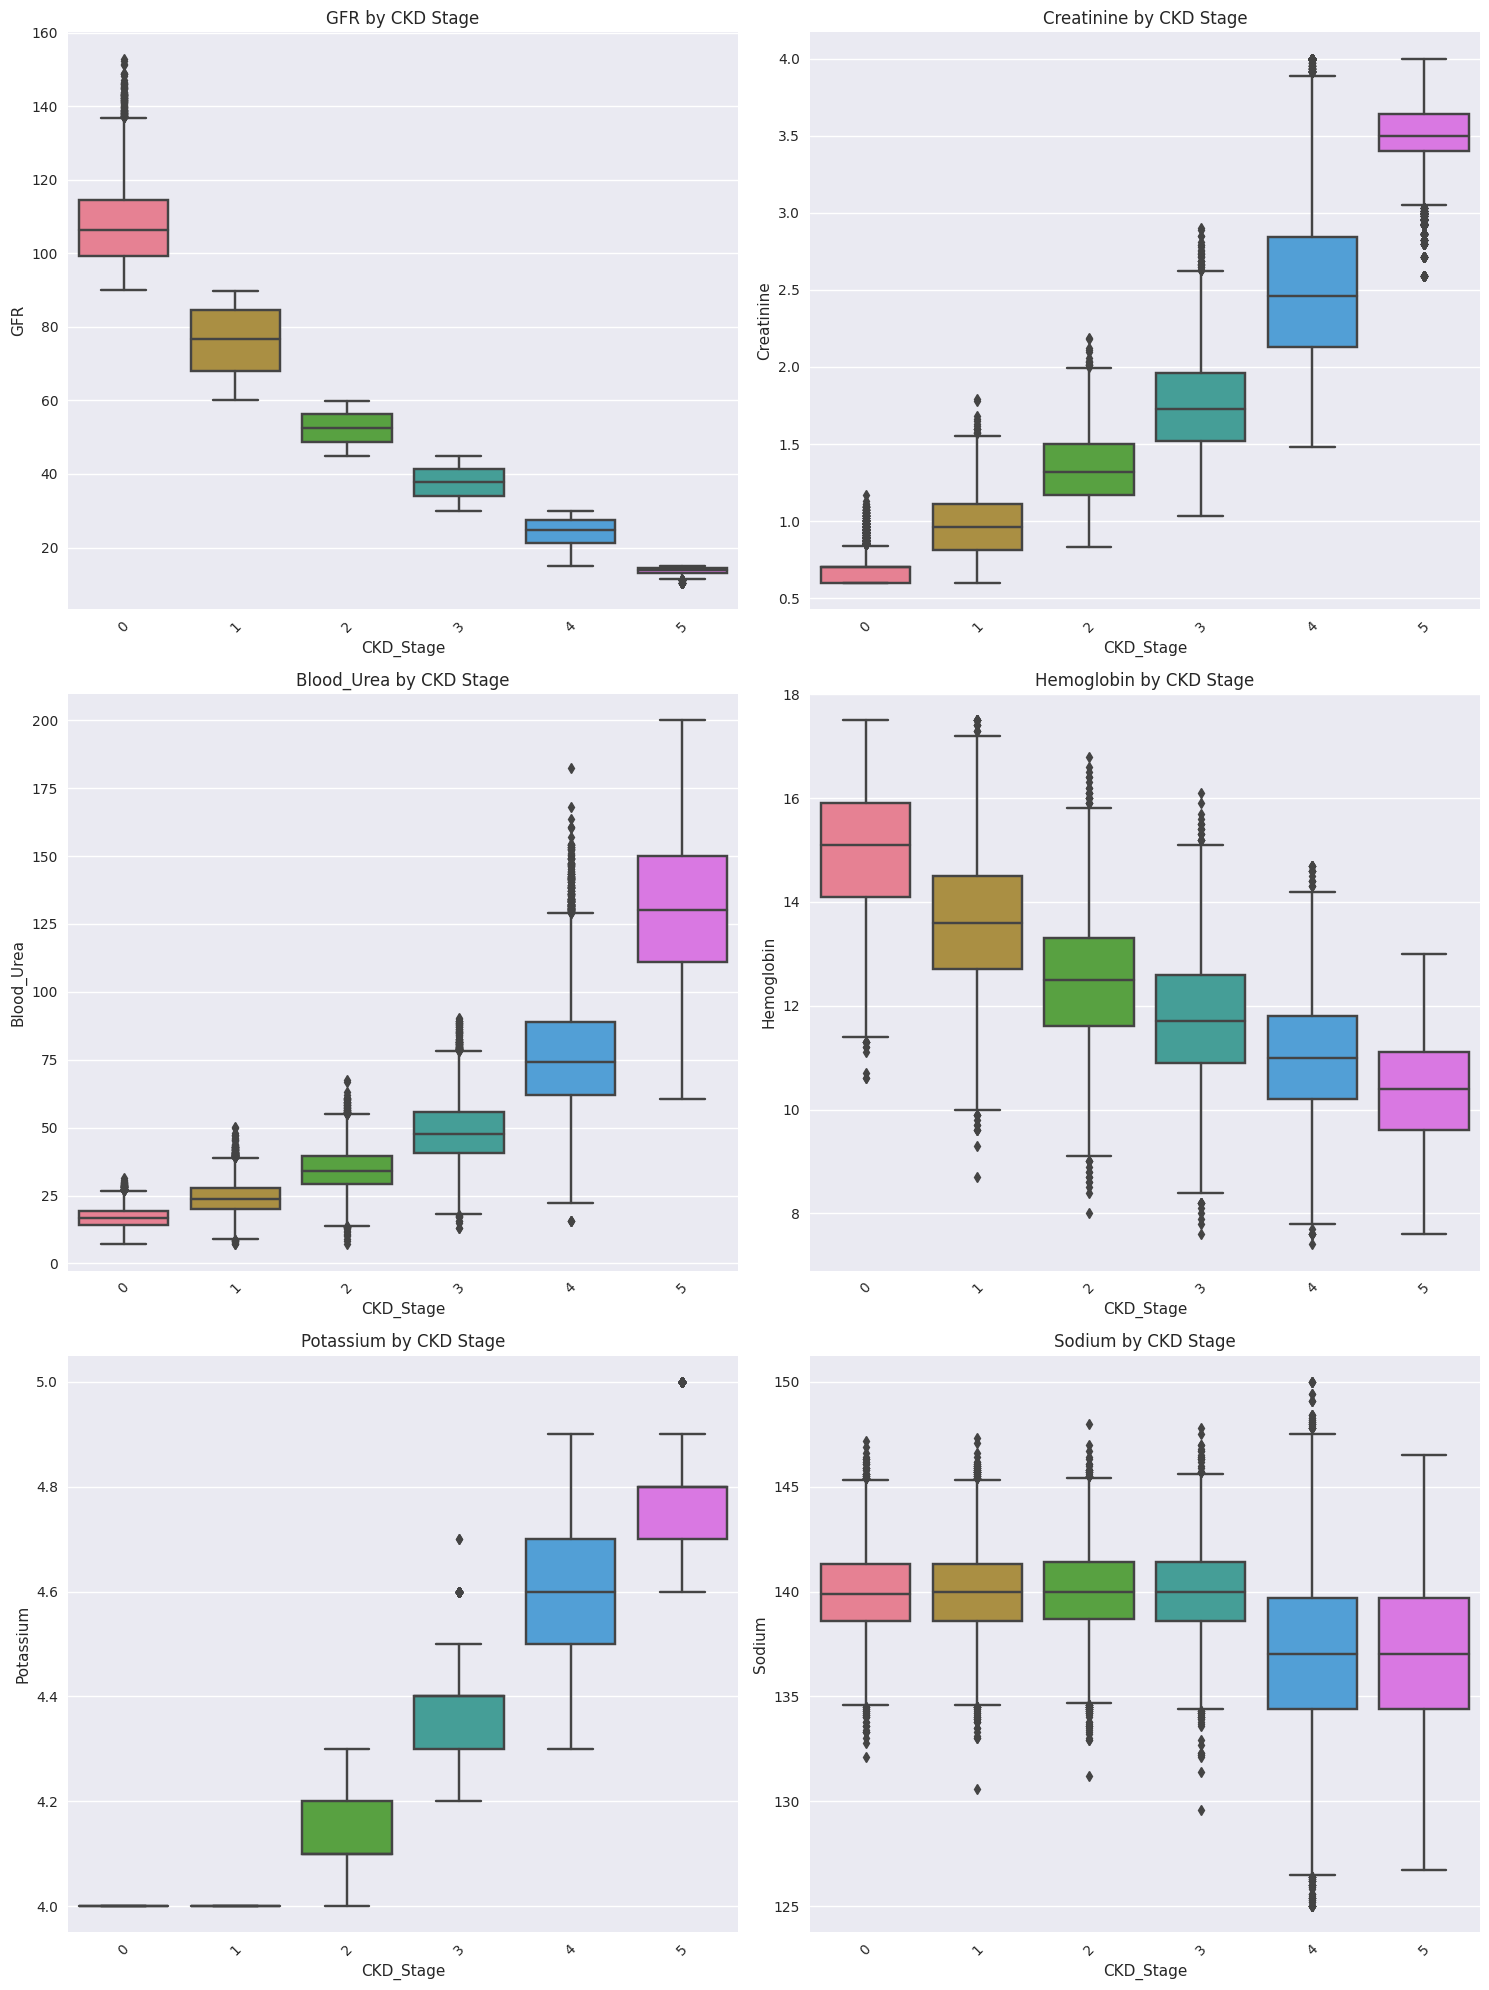


Correlation Summary with CKD Stage:
Potassium: positive strong correlation (0.945)
Creatinine: positive strong correlation (0.925)
Blood_Urea: positive strong correlation (0.862)
Age: positive weak correlation (0.296)
Gender: negative weak correlation (-0.136)
Sodium: negative moderate correlation (-0.376)
Hemoglobin: negative strong correlation (-0.779)
GFR: negative strong correlation (-0.958)


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_correlations_with_ckd(data):
    # Calculate correlations
    correlations = data.corr()['CKD_Stage'].sort_values(ascending=True)
    correlations = correlations.drop('CKD_Stage')  # Remove self-correlation
    correlations = correlations.drop('Gender_encoded')  # Remove duplicate of Gender
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # 1. Horizontal Bar Plot
    colors = ['red' if x < 0 else 'green' for x in correlations]
    correlations.plot(kind='barh', ax=ax1, color=colors)
    ax1.set_title('Feature Correlations with CKD Stage', pad=20, fontsize=14)
    ax1.set_xlabel('Correlation Coefficient')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add correlation values on the bars
    for i, v in enumerate(correlations):
        ax1.text(v + (0.01 if v >= 0 else -0.01), 
                i, 
                f'{v:.3f}', 
                va='center',
                ha='left' if v >= 0 else 'right',
                fontweight='bold')
    
    # 2. Correlation Heatmap
    # Select relevant features for heatmap
    features_for_heatmap = ['CKD_Stage', 'GFR', 'Creatinine', 'Blood_Urea', 
                           'Hemoglobin', 'Potassium', 'Sodium', 'Age', 'Gender']
    correlation_matrix = data[features_for_heatmap].corr()
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                fmt='.2f',
                ax=ax2)
    ax2.set_title('Correlation Matrix Heatmap', pad=20, fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # 3. Pairplot for key features
    key_features = ['GFR', 'Creatinine', 'Blood_Urea', 'Hemoglobin', 'CKD_Stage']
    plt.figure(figsize=(15, 15))
    sns.pairplot(data[key_features], hue='CKD_Stage', diag_kind='kde')
    plt.suptitle('Pairwise Relationships between Key Features', y=1.02, fontsize=14)
    plt.show()
    
    # 4. Feature vs CKD Stage Box Plots
    features_to_plot = ['GFR', 'Creatinine', 'Blood_Urea', 'Hemoglobin', 'Potassium', 'Sodium']
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()
    
    for idx, feature in enumerate(features_to_plot):
        sns.boxplot(data=data, x='CKD_Stage', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} by CKD Stage')
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_feature_correlations_with_ckd(data)

# Print numerical summary
print("\nCorrelation Summary with CKD Stage:")
correlations = data.corr()['CKD_Stage'].sort_values(ascending=False)
for feature, corr in correlations.items():
    if feature != 'CKD_Stage' and feature != 'Gender_encoded':
        strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.3 else "weak"
        direction = "positive" if corr > 0 else "negative"
        print(f"{feature}: {direction} {strength} correlation ({corr:.3f})")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_models_feature_importance(models, X_train_scaled, X_test_scaled, y_train, y_test, feature_names):
    plt.style.use('seaborn')
    
    # Create a figure with subplots for each model
    n_models = len(models)
    fig, axes = plt.subplots(((n_models + 1) // 2), 2, figsize=(15, 5 * ((n_models + 1) // 2)))
    axes = axes.ravel()
    
    for idx, (name, model_dict) in enumerate(models.items()):
        model = model_dict['model']
        
        # Get feature importance based on model type
        if hasattr(model, 'feature_importances_'):
            # For tree-based models
            importances = model.feature_importances_
            std = np.zeros_like(importances)
            
        elif hasattr(model, 'coef_'):
            # For linear models
            importances = np.abs(model.coef_).mean(axis=0) if len(model.coef_.shape) > 1 else np.abs(model.coef_)
            std = np.zeros_like(importances)
            
        else:
            # For other models, use permutation importance
            result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
            importances = result.importances_mean
            std = result.importances_std
        
        # Sort features by importance
        indices = np.argsort(importances)
        
        # Plot feature importance
        ax = axes[idx]
        ax.barh(range(len(indices)), importances[indices], xerr=std[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_title(f'Feature Importance - {name}')
        ax.set_xlabel('Importance')
        
        # Add importance values on the bars
        for i, v in enumerate(importances[indices]):
            ax.text(v + std[indices][i], i, f'{v:.3f}', va='center')
    
    # Remove any empty subplots
    if n_models % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary DataFrame of feature importance for all models
    importance_df = pd.DataFrame()
    
    for name, model_dict in models.items():
        model = model_dict['model']
        
        if hasattr(model, 'feature_importances_'):
            importance_df[name] = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance_df[name] = np.abs(model.coef_).mean(axis=0) if len(model.coef_.shape) > 1 else np.abs(model.coef_)
        else:
            result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
            importance_df[name] = result.importances_mean
    
    importance_df.index = feature_names
    
    # Plot heatmap of feature importance across all models
    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Feature Importance Comparison Across Models')
    plt.ylabel('Features')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nAverage Feature Importance Across All Models:")
    print(importance_df.mean(axis=1).sort_values(ascending=False))
    
    return importance_df

# Get feature names (excluding target variable)
feature_names = data.drop(['CKD_Stage'], axis=1).columns

# Plot feature importance for all models
importance_summary = plot_all_models_feature_importance(
    results, 
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test, 
    feature_names
)

# Compare feature rankings across models
def compare_feature_rankings(importance_df):
    # Get rankings for each model
    rankings = importance_df.rank(ascending=False)
    
    # Calculate average ranking and consistency
    avg_rank = rankings.mean(axis=1)
    rank_std = rankings.std(axis=1)
    
    # Create summary
    ranking_summary = pd.DataFrame({
        'Average Rank': avg_rank,
        'Rank Std Dev': rank_std
    }).sort_values('Average Rank')
    
    print("\nFeature Ranking Consistency:")
    print(ranking_summary)
    
    # Plot ranking consistency
    plt.figure(figsize=(10, 6))
    ranking_summary.plot(kind='bar', y='Rank Std Dev', alpha=0.5)
    plt.title('Feature Ranking Consistency Across Models')
    plt.xlabel('Features')
    plt.ylabel('Standard Deviation of Rank')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Compare rankings
compare_feature_rankings(importance_summary)